In [4]:
# Import Modules Needed

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import erfc
from PIL import Image as im 
from matplotlib import animation, rc
plt.rc('animation', html='jshtml')
from IPython.display import HTML
import subprocess as sp
import sys,math
import sympy as sym
import matplotlib.font_manager
from IPython.core.display import HTML
def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)
code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])
# HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [10]:
# Little function to tell you how long the for loop is running, courtesy of Kirk Long

def trackPercent(place,totalLength,strLen): #percent output tracker
    percent = place/totalLength*10
    if math.floor(percent)==69:
        string="{:.2f} % complete -- nice".format(percent)
    else:
        string="{:.2f} % complete".format(percent)
    sys.stdout.write("\r") #this "moves the cursor" to the beginning of the I0 line
    sys.stdout.write(" "*strLen) #this "clears" whatever was on the line last time by writing whitespace
    sys.stdout.write("\r") #move the cursor back to the start again
    sys.stdout.write(string) #display the current percent we are at
    sys.stdout.flush() #flush finishes call to print() (this is like what's under the hood of print function)
    strLen=len(string) #return the new string length for next function call
    return strLen
#--NotebookApp.iopub_data_rate_limit=1.0e10

In [6]:
# Class function containing various algorithms to solve the diffusion of heat through an asteroid

class pde_solver():
    def __init__(self,L, t_tot, T0, kappa, dz, omega, mu, kk):
    
    #'''
    # Solve the 1d diffusion equation using finite differences method, with inputs for the 
    # spatial range (L), total time (t), initial condition (T0), diffusion coeffecient 
    # (kappa), number of timesteps (Nt), number of spatial nodes (Nz), frequency (omega), physical characteristics
    # constant (mu), and thermal conductivity (kk)
    #'''
        self.L=L;
        self.t_tot=t_tot
        self.T0=T0
        self.kappa=kappa
        self.mu=mu
        self.kk=kk
        self.dz=dz
        self.dt=0.9*(self.dz**2/self.kappa)/2 # Define timestep to satisfy stability req't
        self.r = self.kappa*self.dt/(self.dz**2) # Diffusion condition
        self.d=self.mu*self.kappa/self.kk # radiative loss term
        print("Step size: dt = {:.2e}".format(self.dt))
        self.omega=omega
        self.z = np.arange(0, self.L , self.dz) # Or dz = z[1] - z[0]
        self.Nz = len(self.z)
        self.t = np.arange(0, self.t_tot, self.dt)  
        self.Nt = len(self.t)
        self.T_sol=None
        self.T=None
        self.TR=None
        self.T0_array=self.T0+self.T0*(np.sin(self.omega*self.t))
    
    
    def numerical(self,double=True):
        '''Function to compute, with centered finite differences, the temperature evolution in an asteroid
        rotating in space'''
        
        self.Tr=np.zeros((self.Nt, self.Nz+2))
        print (np.shape(self.Tr))
        self.Tl=np.zeros_like(self.Tr)
        # Set initial condition 
        #self.Tr[0,:] = 0
        #self.Tl[0,:] = 0
        str_len = 0
        # Insert boundary conditions
        self.Tr[:,0] =self.T0-self.T0*np.cos(self.omega*self.t)#+ self.T0*(np.sin(self.omega*self.t -np.pi/2))#self.T0+
        if double:
            self.Tr[:,-1] = self.T0-self.T0*np.cos(self.omega*self.t)#+self.T0*(-np.sin(self.omega*self.t -np.pi/2))
        for i in range(1, self.Nt):

            # Compute u at inner mesh points for i in range(1, Nz):
            self.Tr[i,1:-1] =  self.Tr[i-1,1:-1] + self.r * (self.Tr[i-1,2:] - 2*self.Tr[i-1,1:-1] + self.Tr[i-1,:-2]) 
            #self.Tr[i,-1]=self.Tr[i,-2]-self.d*(self.Tr[i,-2]**4)
            #self.Tr[i,-1]=self.Tr[i,-2]
            #self.Tl[i,1:-1] =  self.Tl[i-1,1:-1] + self.r * (self.Tl[i-1,2:] - 2*self.Tl[i-1,1:-1] + self.Tl[i-1,:-2])
            if float(10*int(i/10))==float(i):
                str_len = trackPercent(i,self.Nt/10,str_len)
                str_len += 1


        self.T =self.Tr[:,1:]
        #print("T, z shapes: ", T.shape, z.shape)
        #return self.T
        
        
    def numerical_plus_radiative(self):
        '''Function to compute the modified diffusion equation, that with a radiative loss term, describing an
        asteroid which loses heat to its surroundings'''
        
        self.TR=np.zeros((self.Nt, self.Nz+2))
        str_len = 0
        # Insert boundary conditions
        self.TR[:,0] =self.T0+ self.T0*np.cos(self.omega*self.t)#self.T0*(np.sin(self.omega*self.t -np.pi/2))#self.T0+

#         if self.d > 0.05:
#             self.mu = 0.04*self.kk/self.kappa
            
        for i in range(1, self.Nt):
            # Compute u at inner mesh points for i in range(1, Nz):
            self.TR[i,1:-1] =  self.TR[i-1,1:-1] + self.r * (self.TR[i-1,2:] - 2*self.TR[i-1,1:-1] + self.TR[i-1,:-2]) 
            self.TR[i,-1]=self.TR[i,-2]-self.d*(self.Tr[i,-2]**4)
            if float(10*int(i/10))==float(i):
                str_len = trackPercent(i,self.Nt/10,str_len)
                str_len += 1
        self.TR=self.Tr[:,1:] 
   
    def analytic(self):
        '''Analytic solution of the 1D diffusion equation to compare against numerical solution'''
        t_a=self.t.reshape(self.Nt,1)
        z_a=self.z.reshape(1,self.Nz)
        self.k = np.sqrt(self.omega/(2*self.r))
        self.a=self.k*z_a - self.omega*t_a
        self.T_sol=np.zeros((self.Nt, self.Nz))
        for i in range(1, self.Nt):#np.exp(self.k*self.z)
            self.T_sol[i]=self.T0*(np.cos(self.k*self.z) -
                                   np.exp(-self.k*self.z)*np.cos(self.omega*self.t[i] - self.k*self.z))
        #self.T_sol=self.T0*np.exp(-zb)*np.sin(zb-tb)
        #self.T0*np.sin(self.omega*self.t).reshape(self.Nt,1)*np.cos(self.k*self.z).reshape(1,self.Nz)#self.T_R+self.T_L
        #self.func=np.exp(-(self.k**2)*self.kappa*t_a)*np.cos(self.k*self.z).reshape(1,self.Nz)
        #return self.T_sol
        


In [7]:
l,w,nu=sym.symbols('lambda omega nu')
sym.solve(l**2+sym.I*w/nu, l)

[-sqrt(-I*omega/nu), sqrt(-I*omega/nu)]

In [8]:
# Let's solve!
solve = pde_solver(L=50, t_tot=5000, T0=1, kappa=1.5, dz=1, omega=0.5e-3,mu=1,kk=5)
solve.numerical(double=False)
#solve.numerical_plus_radiative()
solve.analytic()
#solve2=pde_solver(L=500, t_tot=50000, T0=1, kappa=1.5, dz=1, omega=0.5e-3,mu=1,kk=5)
#solve2.analytic()
#solve2 = pde_solver(L=100, t_tot=100000, T0=3, kappa=0.5, dz=1, omega=1e-2,mu=1e-2,kk=3)
#solve2.numerical(double=False)

Step size: dt = 3.00e-01
(166667, 52)
100.00 % complete        

In [18]:
print(solve.omega*solve.t[50] - solve.k*solve.z)

[ 0.0075     -0.01607023 -0.03964045 -0.06321068 -0.0867809  -0.11035113
 -0.13392136 -0.15749158 -0.18106181 -0.20463203 -0.22820226 -0.25177249
 -0.27534271 -0.29891294 -0.32248316 -0.34605339 -0.36962362 -0.39319384
 -0.41676407 -0.44033429 -0.46390452 -0.48747475 -0.51104497 -0.5346152
 -0.55818542 -0.58175565 -0.60532588 -0.6288961  -0.65246633 -0.67603656
 -0.69960678 -0.72317701 -0.74674723 -0.77031746 -0.79388769 -0.81745791
 -0.84102814 -0.86459836 -0.88816859 -0.91173882 -0.93530904 -0.95887927
 -0.98244949 -1.00601972 -1.02958995 -1.05316017 -1.0767304  -1.10030062
 -1.12387085 -1.14744108]


Radiative loss: 0.3
diffusion term 0.44999999999999996


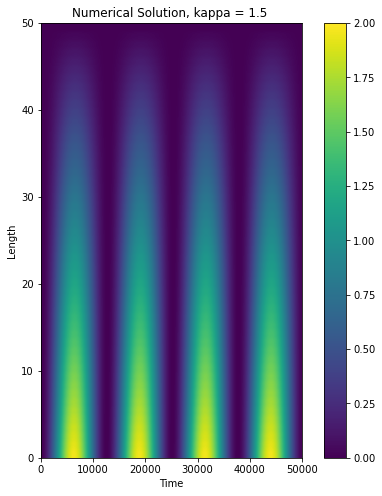

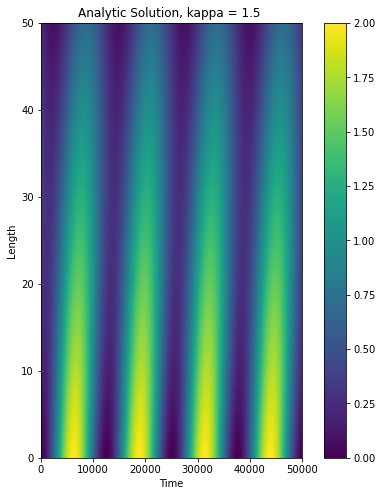

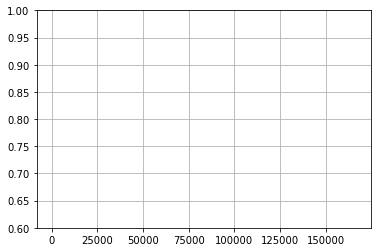

In [9]:
# Plotting

ratio=0.5*solve.Nt/solve.Nz

print ('Radiative loss:',solve.d)
print("diffusion term",solve.r)
#plt.figure(figsize=(8,8))
#plt.imshow(solve2.T.T,vmin=0,vmax=6,aspect=ratio,origin='lower',extent=(0,solve.t_tot,0,solve.L))
#plt.ylabel('Length'); plt.xlabel('Time')
#plt.title('Numerical Solution, kappa = {} '.format(solve2.kappa),size=12)
#plt.colorbar()
#plt.show()
plt.figure(figsize=(8,8))
plt.imshow(solve.T.T,vmin=0,vmax=2,  aspect=ratio,origin='lower',extent=(0,solve.t_tot,0,solve.L))
plt.ylabel('Length'); plt.xlabel('Time')
plt.colorbar()
plt.title('Numerical Solution, kappa = {} '.format(solve.kappa),size=12)
plt.show()

#plt.figure(figsize=(8,8))
#plt.imshow(solve.TR.T,vmin=0,vmax=2,  aspect=ratio,origin='lower',extent=(0,solve.t_tot,0,solve.L))
#plt.ylabel('Length'); plt.xlabel('Time')
#plt.colorbar()
#plt.title('Radiative Numerical Solution, kappa = {} '.format(solve.kappa),size=12)
#plt.show()

plt.figure(figsize=(8,8))
plt.imshow(solve.T_sol.T,vmin=0,vmax=2,  aspect=ratio,origin='lower',extent=(0,solve.t_tot,0,solve.L))
plt.ylabel('Length'); plt.xlabel('Time')
plt.colorbar()
plt.title('Analytic Solution, kappa = {} '.format(solve.kappa),size=12)
plt.show()
plt.plot(solve.T[:,-1],color='k')
plt.plot(solve.T[:,-2],color='red')
plt.plot(solve.T[:,-3],color='blue')
plt.ylim(0.6,1)
plt.grid()

In [ ]:
z0=0#int(len(solve.z)/5)
#plt.plot(solve.t,solve.T_R[:,z0],label='Analytic Solution R')#marker='o',size=20
#plt.plot(solve.t,solve.T_L[:,z0],label='Analytic Solution L')#marker='o',size=20
plt.plot(solve.t,solve.T[:,z0],label='Numerical Solution')
plt.plot(solve.t,solve.T_sol[:,z0],label='Analytic Solution')#marker='o',size=20
plt.legend(loc=0,ncol=1,prop={'size':12},frameon=False)
plt.grid()
plt.show()

## Exploring Parameter Space